# Generate creative QR codes with ControlNet QR Code Monster and OpenVINO™

[Stable Diffusion](https://github.com/CompVis/stable-diffusion), a cutting-edge image generation technique, but it can be further enhanced by combining it with [ControlNet](https://arxiv.org/abs/2302.05543), a widely used control network approach. The combination allows Stable Diffusion to use a condition input to guide the image generation process, resulting in highly accurate and visually appealing images. The condition input could be in the form of various types of data such as scribbles, edge maps, pose key points, depth maps, segmentation maps, normal maps, or any other relevant information that helps to guide the content of the generated image, for example - QR codes! This method can be particularly useful in complex image generation scenarios where precise control and fine-tuning are required to achieve the desired results.

In this tutorial, we will learn how to convert and run [Controlnet QR Code Monster For SD-1.5](https://huggingface.co/monster-labs/control_v1p_sd15_qrcode_monster) by [monster-labs](https://qrcodemonster.art/). An additional part demonstrates how to run quantization with [NNCF](https://github.com/openvinotoolkit/nncf/) to speed up pipeline.

![](https://github.com/openvinotoolkit/openvino_notebooks/assets/76463150/1a5978c6-e7a0-4824-9318-a3d8f4912c47)

If you want to learn more about ControlNet and particularly on conditioning by pose, please refer to this [tutorial](../controlnet-stable-diffusion/controlnet-stable-diffusion.ipynb)


#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Instantiating Generation Pipeline](#Instantiating-Generation-Pipeline)
    - [ControlNet in Diffusers library](#ControlNet-in-Diffusers-library)
- [Convert models to OpenVINO Intermediate representation (IR) format](#Convert-models-to-OpenVINO-Intermediate-representation-(IR)-format)
    - [ControlNet conversion](#ControlNet-conversion)
    - [Text Encoder](#Text-Encoder)
    - [UNet conversion](#UNet-conversion)
    - [VAE Decoder conversion](#VAE-Decoder-conversion)
- [Select inference device for Stable Diffusion pipeline](#Select-inference-device-for-Stable-Diffusion-pipeline)
- [Prepare Inference pipeline](#Prepare-Inference-pipeline)
- [Quantization](#Quantization)
    - [Prepare calibration datasets](#Prepare-calibration-datasets)
    - [Run quantization](#Run-quantization)
    - [Compare model file sizes](#Compare-model-file-sizes)
    - [Compare inference time of the FP16 and INT8 pipelines](#Compare-inference-time-of-the-FP16-and-INT8-pipelines)
- [Running Text-to-Image Generation with ControlNet Conditioning and OpenVINO](#Running-Text-to-Image-Generation-with-ControlNet-Conditioning-and-OpenVINO)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/qrcode-monster/qrcode-monster.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)


In [ ]:
%pip install -q accelerate "diffusers>=0.24.0" transformers "torch>=2.1" "gradio>=4.19" qrcode opencv-python "peft>=0.6.2" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "openvino>=2023.1.0" "nncf>=2.7.0" "matplotlib>=3.4"

## Instantiating Generation Pipeline
[back to top ⬆️](#Table-of-contents:)

### ControlNet in Diffusers library
[back to top ⬆️](#Table-of-contents:)

For working with Stable Diffusion and ControlNet models, we will use Hugging Face [Diffusers](https://github.com/huggingface/diffusers) library. To experiment with ControlNet, Diffusers exposes the [`StableDiffusionControlNetPipeline`](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/controlnet) similar to the [other Diffusers pipelines](https://huggingface.co/docs/diffusers/api/pipelines/overview). Central to the `StableDiffusionControlNetPipeline` is the `controlnet` argument which enables providing a particularly trained [`ControlNetModel`](https://huggingface.co/docs/diffusers/main/en/api/models#diffusers.ControlNetModel) instance while keeping the pre-trained diffusion model weights the same. The code below demonstrates how to create `StableDiffusionControlNetPipeline`, using the `controlnet-openpose` controlnet model and `stable-diffusion-v1-5`:

In [2]:
from diffusers import (
    StableDiffusionControlNetPipeline,
    ControlNetModel,
)

controlnet = ControlNetModel.from_pretrained("monster-labs/control_v1p_sd15_qrcode_monster")

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "botp/stable-diffusion-v1-5",
    controlnet=controlnet,
)

2024-12-05 09:21:58.637418: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 09:21:58.649752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733376118.663808  222102 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733376118.667978  222102 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 09:21:58.683751: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/ea/work/py311/lib/python3.11/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


## Convert models to OpenVINO Intermediate representation (IR) format
[back to top ⬆️](#Table-of-contents:)

We need to provide a model object, input data for model tracing to `ov.convert_model` function to obtain OpenVINO `ov.Model` object instance. Model can be saved on disk for next deployment using `ov.save_model` function.

The pipeline consists of four important parts:

* ControlNet for conditioning by image annotation.
* Text Encoder for creation condition to generate an image from a text prompt.
* Unet for step-by-step denoising latent image representation.
* Autoencoder (VAE) for decoding latent space to image.

In [3]:
import gc
from functools import partial
from pathlib import Path
from PIL import Image
import openvino as ov
import torch


def cleanup_torchscript_cache():
    """
    Helper for removing cached model representation
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()

### ControlNet conversion
[back to top ⬆️](#Table-of-contents:)

The ControlNet model accepts the same inputs like UNet in Stable Diffusion pipeline and additional condition sample - skeleton key points map predicted by pose estimator:

* `sample` - latent image sample from the previous step, generation process has not been started yet, so we will use random noise,
* `timestep` - current scheduler step,
* `encoder_hidden_state` - hidden state of text encoder,
* `controlnet_cond` - condition input annotation.

The output of the model is attention hidden states from down and middle blocks, which serves additional context for the UNet model.

In [4]:
controlnet_ir_path = Path("./controlnet.xml")

controlnet_inputs = {
    "sample": torch.randn((2, 4, 96, 96)),
    "timestep": torch.tensor(1),
    "encoder_hidden_states": torch.randn((2, 77, 768)),
    "controlnet_cond": torch.randn((2, 3, 768, 768)),
}

with torch.no_grad():
    down_block_res_samples, mid_block_res_sample = controlnet(**controlnet_inputs, return_dict=False)

if not controlnet_ir_path.exists():
    controlnet.forward = partial(controlnet.forward, return_dict=False)
    with torch.no_grad():
        ov_model = ov.convert_model(controlnet, example_input=controlnet_inputs)
    ov.save_model(ov_model, controlnet_ir_path)
    del ov_model
    del pipe.controlnet, controlnet
    cleanup_torchscript_cache()
    print("ControlNet successfully converted to IR")
else:
    del pipe.controlnet, controlnet
    print(f"ControlNet will be loaded from {controlnet_ir_path}")

ControlNet will be loaded from controlnet.xml


### Text Encoder
[back to top ⬆️](#Table-of-contents:)

The text-encoder is responsible for transforming the input prompt, for example, "a photo of an astronaut riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple transformer-based encoder that maps a sequence of input tokens to a sequence of latent text embeddings.

The input of the text encoder is tensor `input_ids`, which contains indexes of tokens from text processed by the tokenizer and padded to the maximum length accepted by the model. Model outputs are two tensors: `last_hidden_state` - hidden state from the last MultiHeadAttention layer in the model and `pooler_out` - pooled output for whole model hidden states.

In [5]:
text_encoder_ir_path = Path("./text_encoder.xml")

if not text_encoder_ir_path.exists():
    pipe.text_encoder.eval()
    with torch.no_grad():
        ov_model = ov.convert_model(
            pipe.text_encoder,  # model instance
            example_input=torch.ones((1, 77), dtype=torch.long),  # inputs for model tracing
        )
    ov.save_model(ov_model, text_encoder_ir_path)
    del ov_model
    del pipe.text_encoder
    cleanup_torchscript_cache()
    print("Text Encoder successfully converted to IR")
else:
    del pipe.text_encoder
    print(f"Text Encoder will be loaded from {controlnet_ir_path}")

Text Encoder will be loaded from controlnet.xml


### UNet conversion
[back to top ⬆️](#Table-of-contents:)

The process of UNet model conversion remains the same, like for original Stable Diffusion model, but with respect to the new inputs generated by ControlNet.

In [6]:
from typing import Tuple

unet_ir_path = Path("./unet.xml")

dtype_mapping = {
    torch.float32: ov.Type.f32,
    torch.float64: ov.Type.f64,
    torch.int32: ov.Type.i32,
    torch.int64: ov.Type.i64,
}


def flattenize_inputs(inputs):
    flatten_inputs = []
    for input_data in inputs:
        if input_data is None:
            continue
        if isinstance(input_data, (list, tuple)):
            flatten_inputs.extend(flattenize_inputs(input_data))
        else:
            flatten_inputs.append(input_data)
    return flatten_inputs


class UnetWrapper(torch.nn.Module):
    def __init__(
        self,
        unet,
        sample_dtype=torch.float32,
        timestep_dtype=torch.int64,
        encoder_hidden_states=torch.float32,
        down_block_additional_residuals=torch.float32,
        mid_block_additional_residual=torch.float32,
    ):
        super().__init__()
        self.unet = unet
        self.sample_dtype = sample_dtype
        self.timestep_dtype = timestep_dtype
        self.encoder_hidden_states_dtype = encoder_hidden_states
        self.down_block_additional_residuals_dtype = down_block_additional_residuals
        self.mid_block_additional_residual_dtype = mid_block_additional_residual

    def forward(
        self,
        sample: torch.Tensor,
        timestep: torch.Tensor,
        encoder_hidden_states: torch.Tensor,
        down_block_additional_residuals: Tuple[torch.Tensor],
        mid_block_additional_residual: torch.Tensor,
    ):
        sample.to(self.sample_dtype)
        timestep.to(self.timestep_dtype)
        encoder_hidden_states.to(self.encoder_hidden_states_dtype)
        down_block_additional_residuals = [res.to(self.down_block_additional_residuals_dtype) for res in down_block_additional_residuals]
        mid_block_additional_residual.to(self.mid_block_additional_residual_dtype)
        return self.unet(
            sample,
            timestep,
            encoder_hidden_states,
            down_block_additional_residuals=down_block_additional_residuals,
            mid_block_additional_residual=mid_block_additional_residual,
        )


pipe.unet.eval()
unet_inputs = {
    "sample": torch.randn((2, 4, 96, 96)),
    "timestep": torch.tensor(1),
    "encoder_hidden_states": torch.randn((2, 77, 768)),
    "down_block_additional_residuals": down_block_res_samples,
    "mid_block_additional_residual": mid_block_res_sample,
}

if not unet_ir_path.exists():
    with torch.no_grad():
        ov_model = ov.convert_model(UnetWrapper(pipe.unet), example_input=unet_inputs)

    flatten_inputs = flattenize_inputs(unet_inputs.values())
    for input_data, input_tensor in zip(flatten_inputs, ov_model.inputs):
        input_tensor.get_node().set_partial_shape(ov.PartialShape(input_data.shape))
        input_tensor.get_node().set_element_type(dtype_mapping[input_data.dtype])
    ov_model.validate_nodes_and_infer_types()

    ov.save_model(ov_model, unet_ir_path)
    del ov_model
    cleanup_torchscript_cache()
    del pipe.unet
    gc.collect()
    print("Unet successfully converted to IR")
else:
    del pipe.unet
    print(f"Unet will be loaded from {unet_ir_path}")

Unet will be loaded from unet.xml


### VAE Decoder conversion
[back to top ⬆️](#Table-of-contents:)

The VAE model has two parts, an encoder, and a decoder. The encoder is used to convert the image into a low-dimensional latent representation, which will serve as the input to the U-Net model. The decoder, conversely, transforms the latent representation back into an image.

During latent diffusion training, the encoder is used to get the latent representations (latents) of the images for the forward diffusion process, which applies more and more noise at each step. During inference, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. During inference, we will see that we **only need the VAE decoder**. You can find instructions on how to convert the encoder part in a stable diffusion [notebook](../stable-diffusion-text-to-image/stable-diffusion-text-to-image.ipynb).

In [7]:
vae_ir_path = Path("./vae.xml")


class VAEDecoderWrapper(torch.nn.Module):
    def __init__(self, vae):
        super().__init__()
        vae.eval()
        self.vae = vae

    def forward(self, latents):
        return self.vae.decode(latents)


if not vae_ir_path.exists():
    vae_decoder = VAEDecoderWrapper(pipe.vae)
    latents = torch.zeros((1, 4, 96, 96))

    vae_decoder.eval()
    with torch.no_grad():
        ov_model = ov.convert_model(vae_decoder, example_input=latents)
        ov.save_model(ov_model, vae_ir_path)
    del ov_model
    del pipe.vae
    cleanup_torchscript_cache()
    print("VAE decoder successfully converted to IR")
else:
    del pipe.vae
    print(f"VAE decoder will be loaded from {vae_ir_path}")

VAE decoder will be loaded from vae.xml


## Select inference device for Stable Diffusion pipeline
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [8]:
import requests

if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )
    open("notebook_utils.py", "w").write(r.text)

from notebook_utils import device_widget

device = device_widget()

device

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("qrcode-monster.ipynb")

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

## Prepare Inference pipeline
[back to top ⬆️](#Table-of-contents:)

The stable diffusion model takes both a latent seed and a text prompt as input. The latent seed is then used to generate random latent image representations of size $96 \times 96$ where as the text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder.

Next, the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. In comparison with the original stable-diffusion pipeline, latent image representation, encoder hidden states, and control condition annotation passed via ControlNet on each denoising step for obtaining middle and down blocks attention parameters, these attention blocks results additionally will be provided to the UNet model for the control generation process. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. For Stable Diffusion, it is recommended to use one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py)
- [DDIM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddim.py)
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py)

Theory on how the scheduler algorithm function works is out of scope for this notebook, but in short, you should remember that they compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, it is recommended to look into [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

In this tutorial, instead of using Stable Diffusion's default [`PNDMScheduler`](https://huggingface.co/docs/diffusers/main/en/api/schedulers/pndm), we use [`EulerAncestralDiscreteScheduler`](https://huggingface.co/docs/diffusers/api/schedulers/euler_ancestral), recommended by authors. More information regarding schedulers can be found [here](https://huggingface.co/docs/diffusers/main/en/using-diffusers/schedulers).

The *denoising* process is repeated a given number of times (by default 50) to step-by-step retrieve better latent image representations.
Once complete, the latent image representation is decoded by the decoder part of the variational auto-encoder.

Similarly to Diffusers `StableDiffusionControlNetPipeline`, we define our own `OVContrlNetStableDiffusionPipeline` inference pipeline based on OpenVINO.

In [9]:
from diffusers import DiffusionPipeline
from transformers import CLIPTokenizer
from typing import Union, List, Optional, Tuple
import cv2
import numpy as np


def scale_fit_to_window(dst_width: int, dst_height: int, image_width: int, image_height: int):
    """
    Preprocessing helper function for calculating image size for resize with peserving original aspect ratio
    and fitting image to specific window size

    Parameters:
      dst_width (int): destination window width
      dst_height (int): destination window height
      image_width (int): source image width
      image_height (int): source image height
    Returns:
      result_width (int): calculated width for resize
      result_height (int): calculated height for resize
    """
    im_scale = min(dst_height / image_height, dst_width / image_width)
    return int(im_scale * image_width), int(im_scale * image_height)


def preprocess(image: Image.Image):
    """
    Image preprocessing function. Takes image in PIL.Image format, resizes it to keep aspect ration and fits to model input window 768x768,
    then converts it to np.ndarray and adds padding with zeros on right or bottom side of image (depends from aspect ratio), after that
    converts data to float32 data type and change range of values from [0, 255] to [-1, 1], finally, converts data layout from planar NHWC to NCHW.
    The function returns preprocessed input tensor and padding size, which can be used in postprocessing.

    Parameters:
      image (Image.Image): input image
    Returns:
       image (np.ndarray): preprocessed image tensor
       pad (Tuple[int]): pading size for each dimension for restoring image size in postprocessing
    """
    src_width, src_height = image.size
    dst_width, dst_height = scale_fit_to_window(768, 768, src_width, src_height)
    image = image.convert("RGB")
    image = np.array(image.resize((dst_width, dst_height), resample=Image.Resampling.LANCZOS))[None, :]
    pad_width = 768 - dst_width
    pad_height = 768 - dst_height
    pad = ((0, 0), (0, pad_height), (0, pad_width), (0, 0))
    image = np.pad(image, pad, mode="constant")
    image = image.astype(np.float32) / 255.0
    image = image.transpose(0, 3, 1, 2)
    return image, pad


def randn_tensor(
    shape: Union[Tuple, List],
    dtype: Optional[np.dtype] = np.float32,
):
    """
    Helper function for generation random values tensor with given shape and data type

    Parameters:
      shape (Union[Tuple, List]): shape for filling random values
      dtype (np.dtype, *optiona*, np.float32): data type for result
    Returns:
      latents (np.ndarray): tensor with random values with given data type and shape (usually represents noise in latent space)
    """
    latents = np.random.randn(*shape).astype(dtype)

    return latents


class OVContrlNetStableDiffusionPipeline(DiffusionPipeline):
    """
    OpenVINO inference pipeline for Stable Diffusion with ControlNet guidence
    """

    def __init__(
        self,
        tokenizer: CLIPTokenizer,
        scheduler,
        core: ov.Core,
        controlnet: ov.Model,
        text_encoder: ov.Model,
        unet: ov.Model,
        vae_decoder: ov.Model,
        device: str = "AUTO",
    ):
        super().__init__()
        self.tokenizer = tokenizer
        self.vae_scale_factor = 8
        self.scheduler = scheduler
        self.load_models(core, device, controlnet, text_encoder, unet, vae_decoder)
        self.set_progress_bar_config(disable=True)

    def load_models(
        self,
        core: ov.Core,
        device: str,
        controlnet: ov.Model,
        text_encoder: ov.Model,
        unet: ov.Model,
        vae_decoder: ov.Model,
    ):
        """
        Function for loading models on device using OpenVINO

        Parameters:
          core (Core): OpenVINO runtime Core class instance
          device (str): inference device
          controlnet (Model): OpenVINO Model object represents ControlNet
          text_encoder (Model): OpenVINO Model object represents text encoder
          unet (Model): OpenVINO Model object represents UNet
          vae_decoder (Model): OpenVINO Model object represents vae decoder
        Returns
          None
        """
        self.text_encoder = core.compile_model(text_encoder, device)
        self.text_encoder_out = self.text_encoder.output(0)
        self.register_to_config(controlnet=core.compile_model(controlnet, device))
        self.register_to_config(unet=core.compile_model(unet, device))
        self.unet_out = self.unet.output(0)
        self.vae_decoder = core.compile_model(vae_decoder, device)
        self.vae_decoder_out = self.vae_decoder.output(0)

    def __call__(
        self,
        prompt: Union[str, List[str]],
        image: Image.Image,
        num_inference_steps: int = 10,
        negative_prompt: Union[str, List[str]] = None,
        guidance_scale: float = 7.5,
        controlnet_conditioning_scale: float = 1.0,
        eta: float = 0.0,
        latents: Optional[np.array] = None,
        output_type: Optional[str] = "pil",
    ):
        """
        Function invoked when calling the pipeline for generation.

        Parameters:
            prompt (`str` or `List[str]`):
                The prompt or prompts to guide the image generation.
            image (`Image.Image`):
                `Image`, or tensor representing an image batch which will be repainted according to `prompt`.
            num_inference_steps (`int`, *optional*, defaults to 100):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            negative_prompt (`str` or `List[str]`):
                negative prompt or prompts for generation
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality. This pipeline requires a value of at least `1`.
            latents (`np.ndarray`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `Image.Image` or `np.array`.
        Returns:
            image ([List[Union[np.ndarray, Image.Image]]): generaited images

        """

        # 1. Define call parameters
        batch_size = 1 if isinstance(prompt, str) else len(prompt)
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # 2. Encode input prompt
        text_embeddings = self._encode_prompt(prompt, negative_prompt=negative_prompt)

        # 3. Preprocess image
        orig_width, orig_height = image.size
        image, pad = preprocess(image)
        height, width = image.shape[-2:]
        if do_classifier_free_guidance:
            image = np.concatenate(([image] * 2))

        # 4. set timesteps
        self.scheduler.set_timesteps(num_inference_steps)
        timesteps = self.scheduler.timesteps

        # 6. Prepare latent variables
        num_channels_latents = 4
        latents = self.prepare_latents(
            batch_size,
            num_channels_latents,
            height,
            width,
            text_embeddings.dtype,
            latents,
        )

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # Expand the latents if we are doing classifier free guidance.
                # The latents are expanded 3 times because for pix2pix the guidance\
                # is applied for both the text and the input image.
                latent_model_input = np.concatenate([latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                result = self.controlnet([latent_model_input, t, text_embeddings, image])
                down_and_mid_blok_samples = [sample * controlnet_conditioning_scale for _, sample in result.items()]

                # predict the noise residual
                noise_pred = self.unet([latent_model_input, t, text_embeddings, *down_and_mid_blok_samples])[self.unet_out]

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred[0], noise_pred[1]
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(torch.from_numpy(noise_pred), t, torch.from_numpy(latents)).prev_sample.numpy()

                # update progress
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()

        # 8. Post-processing
        image = self.decode_latents(latents, pad)

        # 9. Convert to PIL
        if output_type == "pil":
            image = self.numpy_to_pil(image)
            image = [img.resize((orig_width, orig_height), Image.Resampling.LANCZOS) for img in image]
        else:
            image = [cv2.resize(img, (orig_width, orig_width)) for img in image]

        return image

    def _encode_prompt(
        self,
        prompt: Union[str, List[str]],
        num_images_per_prompt: int = 1,
        do_classifier_free_guidance: bool = True,
        negative_prompt: Union[str, List[str]] = None,
    ):
        """
        Encodes the prompt into text encoder hidden states.

        Parameters:
            prompt (str or list(str)): prompt to be encoded
            num_images_per_prompt (int): number of images that should be generated per prompt
            do_classifier_free_guidance (bool): whether to use classifier free guidance or not
            negative_prompt (str or list(str)): negative prompt to be encoded
        Returns:
            text_embeddings (np.ndarray): text encoder hidden states
        """
        batch_size = len(prompt) if isinstance(prompt, list) else 1

        # tokenize input prompts
        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
        text_input_ids = text_inputs.input_ids

        text_embeddings = self.text_encoder(text_input_ids)[self.text_encoder_out]

        # duplicate text embeddings for each generation per prompt
        if num_images_per_prompt != 1:
            bs_embed, seq_len, _ = text_embeddings.shape
            text_embeddings = np.tile(text_embeddings, (1, num_images_per_prompt, 1))
            text_embeddings = np.reshape(text_embeddings, (bs_embed * num_images_per_prompt, seq_len, -1))

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            uncond_tokens: List[str]
            max_length = text_input_ids.shape[-1]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            else:
                uncond_tokens = negative_prompt
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="np",
            )

            uncond_embeddings = self.text_encoder(uncond_input.input_ids)[self.text_encoder_out]

            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = uncond_embeddings.shape[1]
            uncond_embeddings = np.tile(uncond_embeddings, (1, num_images_per_prompt, 1))
            uncond_embeddings = np.reshape(uncond_embeddings, (batch_size * num_images_per_prompt, seq_len, -1))

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = np.concatenate([uncond_embeddings, text_embeddings])

        return text_embeddings

    def prepare_latents(
        self,
        batch_size: int,
        num_channels_latents: int,
        height: int,
        width: int,
        dtype: np.dtype = np.float32,
        latents: np.ndarray = None,
    ):
        """
        Preparing noise to image generation. If initial latents are not provided, they will be generated randomly,
        then prepared latents scaled by the standard deviation required by the scheduler

        Parameters:
           batch_size (int): input batch size
           num_channels_latents (int): number of channels for noise generation
           height (int): image height
           width (int): image width
           dtype (np.dtype, *optional*, np.float32): dtype for latents generation
           latents (np.ndarray, *optional*, None): initial latent noise tensor, if not provided will be generated
        Returns:
           latents (np.ndarray): scaled initial noise for diffusion
        """
        shape = (
            batch_size,
            num_channels_latents,
            height // self.vae_scale_factor,
            width // self.vae_scale_factor,
        )
        if latents is None:
            latents = randn_tensor(shape, dtype=dtype)
        else:
            latents = latents

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * np.array(self.scheduler.init_noise_sigma)
        return latents

    def decode_latents(self, latents: np.array, pad: Tuple[int]):
        """
        Decode predicted image from latent space using VAE Decoder and unpad image result

        Parameters:
           latents (np.ndarray): image encoded in diffusion latent space
           pad (Tuple[int]): each side padding sizes obtained on preprocessing step
        Returns:
           image: decoded by VAE decoder image
        """
        latents = 1 / 0.18215 * latents
        image = self.vae_decoder(latents)[self.vae_decoder_out]
        (_, end_h), (_, end_w) = pad[1:3]
        h, w = image.shape[2:]
        unpad_h = h - end_h
        unpad_w = w - end_w
        image = image[:, :, :unpad_h, :unpad_w]
        image = np.clip(image / 2 + 0.5, 0, 1)
        image = np.transpose(image, (0, 2, 3, 1))
        return image

In [10]:
import qrcode


def create_code(content: str):
    """Creates QR codes with provided content."""
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_H,
        box_size=16,
        border=0,
    )
    qr.add_data(content)
    qr.make(fit=True)
    img = qr.make_image(fill_color="black", back_color="white")
    img.save("base_qrcode.png")
    img = Image.open("base_qrcode.png")

    # find smallest image size multiple of 256 that can fit qr
    offset_min = 8 * 16
    w, h = img.size
    w = (w + 255 + offset_min) // 256 * 256
    h = (h + 255 + offset_min) // 256 * 256
    if w > 1024:
        raise RuntimeError("QR code is too large, please use a shorter content")
    bg = Image.new("L", (w, h), 128)

    # align on 16px grid
    coords = ((w - img.size[0]) // 2 // 16 * 16, (h - img.size[1]) // 2 // 16 * 16)
    bg.paste(img, coords)
    return bg

In [11]:
from transformers import CLIPTokenizer
from diffusers import EulerAncestralDiscreteScheduler

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

core = ov.Core()

ov_pipe = OVContrlNetStableDiffusionPipeline(
    tokenizer,
    scheduler,
    core,
    controlnet_ir_path,
    text_encoder_ir_path,
    unet_ir_path,
    vae_ir_path,
    device=device.value,
)

/home/ea/work/py311/lib/python3.11/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `unet` directly via 'OVContrlNetStableDiffusionPipeline' object attribute is deprecated. Please access 'unet' over 'OVContrlNetStableDiffusionPipeline's config object instead, e.g. 'scheduler.config.unet'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Now, let's see model in action

/home/ea/work/py311/lib/python3.11/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `controlnet` directly via 'OVContrlNetStableDiffusionPipeline' object attribute is deprecated. Please access 'controlnet' over 'OVContrlNetStableDiffusionPipeline's config object instead, e.g. 'scheduler.config.controlnet'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


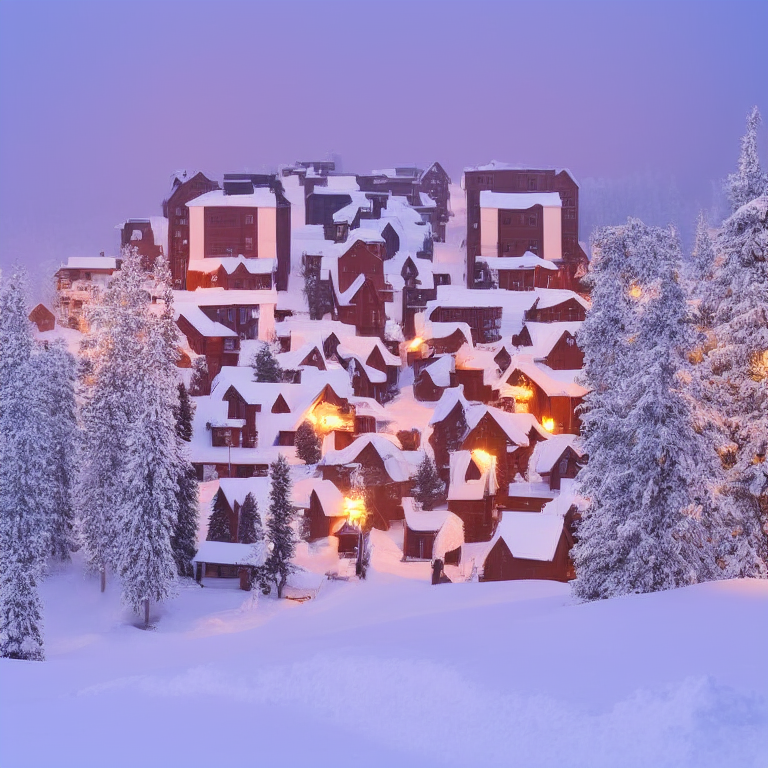

In [12]:
np.random.seed(42)

qrcode_image = create_code("Hi OpenVINO")
image = ov_pipe(
    "cozy town on snowy mountain slope 8k",
    qrcode_image,
    negative_prompt="blurry unreal occluded",
    num_inference_steps=25,
    guidance_scale=7.7,
    controlnet_conditioning_scale=1.4,
)[0]

image

## Quantization
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.

According to `OVContrlNetStableDiffusionPipeline` structure, ControlNet and UNet are used in the cycle repeating inference on each diffusion step, while other parts of pipeline take part only once. That is why computation cost and speed of ControlNet and UNet become the critical path in the pipeline. Quantizing the rest of the SD pipeline does not significantly improve inference performance but can lead to a substantial degradation of accuracy.

The optimization process contains the following steps:

1. Create a calibration dataset for quantization.
2. Run `nncf.quantize()` to obtain quantized model.
3. Save the `INT8` model using `openvino.save_model()` function.

Please select below whether you would like to run quantization to improve model inference speed.

In [13]:
from notebook_utils import quantization_widget

skip_for_device = "GPU" in device.value
to_quantize = quantization_widget(not skip_for_device)
to_quantize

Checkbox(value=True, description='Quantization')

Let's load `skip magic` extension to skip quantization if `to_quantize` is not selected

In [14]:
# Fetch `skip_kernel_extension` module
import requests

if not Path("skip_kernel_extension.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
    )
    open("skip_kernel_extension.py", "w").write(r.text)

int8_pipe = None

%load_ext skip_kernel_extension

### Prepare calibration datasets
[back to top ⬆️](#Table-of-contents:)

We use a prompts below as calibration data for ControlNet and UNet.
To collect intermediate model inputs for calibration we should customize `CompiledModel`.

In [15]:
%%skip not $to_quantize.value

text_prompts = [
    "a bilboard in NYC with a qrcode",
    "a samurai side profile, realistic, 8K, fantasy",
    "A sky view of a colorful lakes and rivers flowing through the desert",
    "Bright sunshine coming through the cracks of a wet, cave wall of big rocks",
    "A city view with clouds",
    "A forest overlooking a mountain",
    "Sky view of highly aesthetic, ancient greek thermal baths  in beautiful nature",
    "A dream-like futuristic city with the light trails of cars zipping through it's many streets",
]

negative_prompts = [
    "blurry unreal occluded",
    "low contrast disfigured uncentered mangled",
    "amateur out of frame low quality nsfw",
    "ugly underexposed jpeg artifacts",
    "low saturation disturbing content",
    "overexposed severe distortion",
    "amateur NSFW",
    "ugly mutilated out of frame disfigured.",
]

qr_code_contents = [
    "Hugging Face",
    "pre-trained diffusion model",
    "image generation technique",
    "control network",
    "AI QR Code Generator",
    "Explore NNCF today!",
    "Join OpenVINO community",
    "network compression",
]
qrcode_images = [create_code(content) for content in qr_code_contents]

In [16]:
%%skip not $to_quantize.value

from tqdm.notebook import tqdm
from transformers import set_seed
from typing import Any, Dict, List

set_seed(1)

num_inference_steps = 25

class CompiledModelDecorator(ov.CompiledModel):
    def __init__(self, compiled_model, prob: float):
        super().__init__(compiled_model)
        self.data_cache = []
        self.prob = np.clip(prob, 0, 1)

    def __call__(self, *args, **kwargs):
        if np.random.rand() >= self.prob:
            self.data_cache.append(*args)
        return super().__call__(*args, **kwargs)

def collect_calibration_data(pipeline: OVContrlNetStableDiffusionPipeline, subset_size: int) -> List[Dict]:
    original_unet = pipeline.unet
    pipeline.unet = CompiledModelDecorator(original_unet, prob=0)
    pipeline.set_progress_bar_config(disable=True)

    pbar = tqdm(total=subset_size)
    diff = 0
    for prompt, qrcode_image, negative_prompt in zip(text_prompts, qrcode_images, negative_prompts):
        _ = pipeline(
            prompt,
            qrcode_image,
            negative_prompt=negative_prompt,
            num_inference_steps=num_inference_steps,
        )
        collected_subset_size = len(pipeline.unet.data_cache)
        pbar.update(collected_subset_size - diff)
        if collected_subset_size >= subset_size:
            break
        diff = collected_subset_size

    calibration_dataset = pipeline.unet.data_cache
    pipeline.set_progress_bar_config(disable=False)
    pipeline.unet = original_unet
    return calibration_dataset

In [17]:
%%skip not $to_quantize.value

CONTROLNET_INT8_OV_PATH = Path("controlnet_int8.xml")
UNET_INT8_OV_PATH = Path("unet_int8.xml")

if not (CONTROLNET_INT8_OV_PATH.exists() and UNET_INT8_OV_PATH.exists()):
    subset_size = 200
    unet_calibration_data = collect_calibration_data(ov_pipe, subset_size=subset_size)

The first three inputs of ControlNet are the same as the inputs of UNet, the last ControlNet input is a preprocessed `qrcode_image`.

In [18]:
%%skip not $to_quantize.value

if not CONTROLNET_INT8_OV_PATH.exists():
    control_calibration_data = []
    prev_idx = 0
    for qrcode_image in qrcode_images:
        preprocessed_image, _ = preprocess(qrcode_image)
        for i in range(prev_idx, prev_idx + num_inference_steps):
            control_calibration_data.append(unet_calibration_data[i][:3] + [preprocessed_image])
        prev_idx += num_inference_steps

### Run quantization
[back to top ⬆️](#Table-of-contents:)

Create a quantized model from the pre-trained converted OpenVINO model. `FastBiasCorrection` algorithm is disabled due to minimal accuracy improvement in SD models and increased quantization time.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

In [19]:
%%skip not $to_quantize.value

import nncf

if not UNET_INT8_OV_PATH.exists():
    unet = core.read_model(unet_ir_path)
    quantized_unet = nncf.quantize(
        model=unet,
        calibration_dataset=nncf.Dataset(unet_calibration_data),
        subset_size=subset_size,
        model_type=nncf.ModelType.TRANSFORMER,
        advanced_parameters=nncf.AdvancedQuantizationParameters(
            disable_bias_correction=True
        )
    )
    ov.save_model(quantized_unet, UNET_INT8_OV_PATH)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


In [20]:
%%skip not $to_quantize.value

if not CONTROLNET_INT8_OV_PATH.exists():
    controlnet = core.read_model(controlnet_ir_path)
    quantized_controlnet = nncf.quantize(
        model=controlnet,
        calibration_dataset=nncf.Dataset(control_calibration_data),
        subset_size=subset_size,
        model_type=nncf.ModelType.TRANSFORMER,
        advanced_parameters=nncf.AdvancedQuantizationParameters(
            disable_bias_correction=True
        )
    )
    ov.save_model(quantized_controlnet, CONTROLNET_INT8_OV_PATH)

Let's compare the images generated by the original and optimized pipelines.

In [21]:
%%skip not $to_quantize.value

np.random.seed(int(42))
int8_pipe = OVContrlNetStableDiffusionPipeline(tokenizer, scheduler, core, CONTROLNET_INT8_OV_PATH, text_encoder_ir_path, UNET_INT8_OV_PATH, vae_ir_path, device=device.value)

int8_image = int8_pipe(
        "cozy town on snowy mountain slope 8k",
        qrcode_image,
        negative_prompt="blurry unreal occluded",
        num_inference_steps=25,
        guidance_scale=7.7,
        controlnet_conditioning_scale=1.4
)[0]

/home/ea/work/py311/lib/python3.11/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `unet` directly via 'OVContrlNetStableDiffusionPipeline' object attribute is deprecated. Please access 'unet' over 'OVContrlNetStableDiffusionPipeline's config object instead, e.g. 'scheduler.config.unet'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/home/ea/work/py311/lib/python3.11/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `controlnet` directly via 'OVContrlNetStableDiffusionPipeline' object attribute is deprecated. Please access 'controlnet' over 'OVContrlNetStableDiffusionPipeline's config object instead, e.g. 'scheduler.config.controlnet'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


In [22]:
%%skip not $to_quantize.value

import matplotlib.pyplot as plt

def visualize_results(orig_img:Image.Image, optimized_img:Image.Image):
    """
    Helper function for results visualization

    Parameters:
       orig_img (Image.Image): generated image using FP16 models
       optimized_img (Image.Image): generated image using quantized models
    Returns:
       fig (matplotlib.pyplot.Figure): matplotlib generated figure contains drawing result
    """
    orig_title = "FP16 pipeline"
    control_title = "INT8 pipeline"
    figsize = (20, 20)
    fig, axs = plt.subplots(1, 2, figsize=figsize, sharex='all', sharey='all')
    list_axes = list(axs.flat)
    for a in list_axes:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.grid(False)
    list_axes[0].imshow(np.array(orig_img))
    list_axes[1].imshow(np.array(optimized_img))
    list_axes[0].set_title(orig_title, fontsize=15)
    list_axes[1].set_title(control_title, fontsize=15)

    fig.subplots_adjust(wspace=0.01, hspace=0.01)
    fig.tight_layout()
    return fig

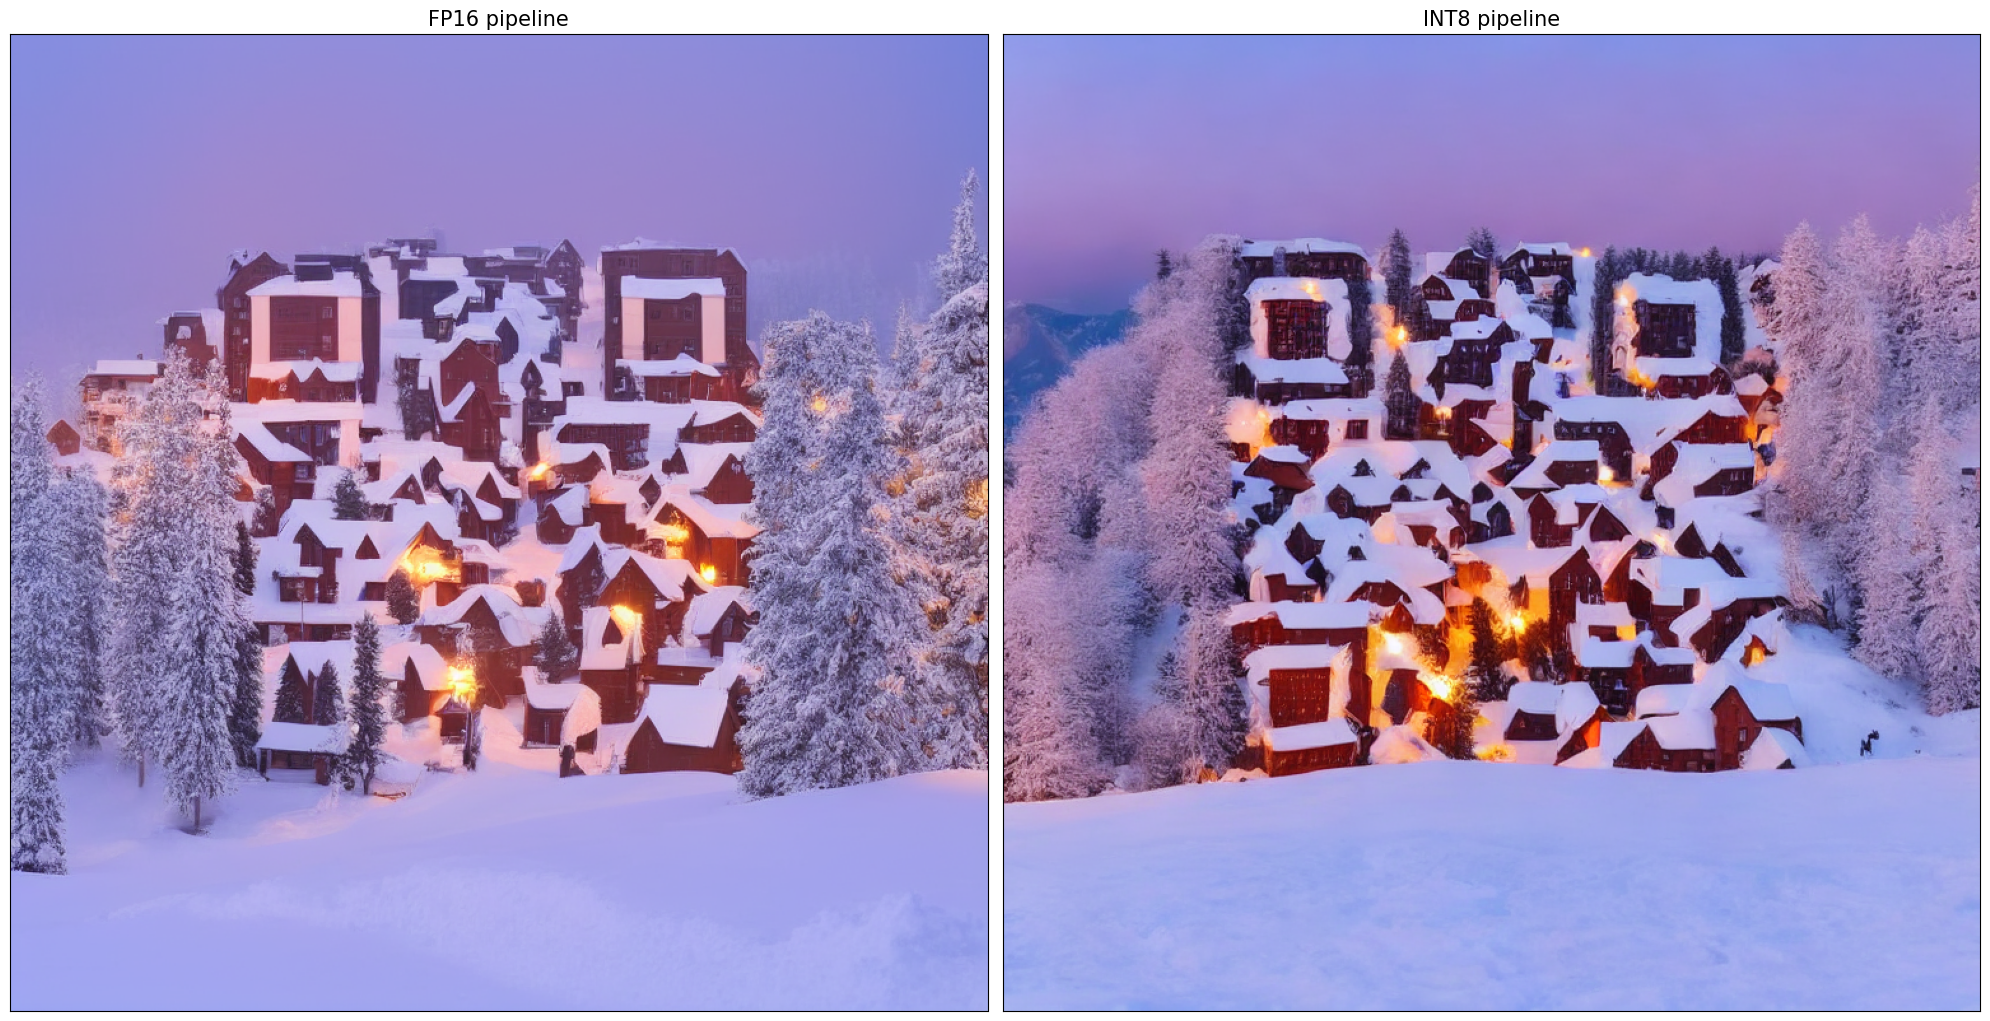

In [23]:
%%skip not $to_quantize.value

fig = visualize_results(image, int8_image)

### Compare model file sizes
[back to top ⬆️](#Table-of-contents:)

In [24]:
%%skip not $to_quantize.value

fp16_ir_model_size = unet_ir_path.with_suffix(".bin").stat().st_size / 2**20
quantized_model_size = UNET_INT8_OV_PATH.with_suffix(".bin").stat().st_size / 2**20

print(f"FP16 UNet size: {fp16_ir_model_size:.2f} MB")
print(f"INT8 UNet size: {quantized_model_size:.2f} MB")
print(f"UNet compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

FP16 UNet size: 1639.41 MB
INT8 UNet size: 821.79 MB
UNet compression rate: 1.995


In [25]:
%%skip not $to_quantize.value

fp16_ir_model_size = controlnet_ir_path.with_suffix(".bin").stat().st_size / 2**20
quantized_model_size = CONTROLNET_INT8_OV_PATH.with_suffix(".bin").stat().st_size / 2**20

print(f"FP16 ControlNet size: {fp16_ir_model_size:.2f} MB")
print(f"INT8 ControlNet size: {quantized_model_size:.2f} MB")
print(f"ControlNet compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

FP16 ControlNet size: 689.09 MB
INT8 ControlNet size: 345.55 MB
ControlNet compression rate: 1.994


### Compare inference time of the FP16 and INT8 pipelines
[back to top ⬆️](#Table-of-contents:)

To measure the inference performance of the `FP16` and `INT8` pipelines, we use mean inference time on 3 samples.

> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications.

In [26]:
%%skip not $to_quantize.value

import time

def calculate_inference_time(pipeline):
    inference_time = []
    pipeline.set_progress_bar_config(disable=True)
    for i in range(3):
        prompt, qrcode_image = text_prompts[i], qrcode_images[i]
        start = time.perf_counter()
        _ = pipeline(prompt, qrcode_image, num_inference_steps=25)
        end = time.perf_counter()
        delta = end - start
        inference_time.append(delta)
    pipeline.set_progress_bar_config(disable=False)
    return np.mean(inference_time)

In [27]:
%%skip not $to_quantize.value

fp_latency = calculate_inference_time(ov_pipe)
print(f"FP16 pipeline: {fp_latency:.3f} seconds")
int8_latency = calculate_inference_time(int8_pipe)
print(f"INT8 pipeline: {int8_latency:.3f} seconds")
print(f"Performance speed up: {fp_latency / int8_latency:.3f}")

/home/ea/work/py311/lib/python3.11/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `controlnet` directly via 'OVContrlNetStableDiffusionPipeline' object attribute is deprecated. Please access 'controlnet' over 'OVContrlNetStableDiffusionPipeline's config object instead, e.g. 'scheduler.config.controlnet'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/home/ea/work/py311/lib/python3.11/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `unet` directly via 'OVContrlNetStableDiffusionPipeline' object attribute is deprecated. Please access 'unet' over 'OVContrlNetStableDiffusionPipeline's config object instead, e.g. 'scheduler.config.unet'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


FP16 pipeline: 176.250 seconds
INT8 pipeline: 119.885 seconds
Performance speed up: 1.470


## Running Text-to-Image Generation with ControlNet Conditioning and OpenVINO
[back to top ⬆️](#Table-of-contents:)

Now, we are ready to start generation. For improving the generation process, we also introduce an opportunity to provide a `negative prompt`. Technically, positive prompt steers the diffusion toward the images associated with it, while negative prompt steers the diffusion away from it. More explanation of how it works can be found in this [article](https://stable-diffusion-art.com/how-negative-prompt-work/). We can keep this field empty if we want to generate image without negative prompting.

Please select below whether you would like to use the quantized model to launch the interactive demo.

In [28]:
import ipywidgets as widgets

quantized_model_present = int8_pipe is not None

use_quantized_model = widgets.Checkbox(
    value=True if quantized_model_present else False,
    description="Use quantized model",
    disabled=not quantized_model_present,
)

use_quantized_model

Checkbox(value=True, description='Use quantized model')

In [29]:
import gradio as gr

pipeline = int8_pipe if use_quantized_model.value else ov_pipe


def _generate(
    qr_code_content: str,
    prompt: str,
    negative_prompt: str,
    seed: Optional[int] = 42,
    guidance_scale: float = 10.0,
    controlnet_conditioning_scale: float = 2.0,
    num_inference_steps: int = 5,
    progress=gr.Progress(track_tqdm=True),
):
    if seed is not None:
        np.random.seed(int(seed))
    qrcode_image = create_code(qr_code_content)
    return pipeline(
        prompt,
        qrcode_image,
        negative_prompt=negative_prompt,
        num_inference_steps=int(num_inference_steps),
        guidance_scale=guidance_scale,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
    )[0]

In [ ]:
if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/qrcode-monster/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo

demo = make_demo(fn=_generate)

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# If you are launching remotely, specify server_name and server_port
# EXAMPLE: `demo.launch(server_name='your server name', server_port='server port in int')`
# To learn more please refer to the Gradio docs: https://gradio.app/docs/